<a href="https://colab.research.google.com/github/inechita/Tensors-in-Quantum-Information-Theory-2025/blob/main/Trasnformer_for_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explanation
Data Generation:
The generate_data function creates sequences of random numbers with one anomaly per sample. The anomaly is inserted by adding a large positive or negative spike to a randomly chosen position. The corresponding label array is binary with a 1 at the anomaly index.

Models:

The with-attention model first uses a dense layer to project the 1-dimensional input into a higher-dimensional space. It then applies a Keras MultiHeadAttention layer to perform self-attention over the sequence. A residual connection and layer normalization follow, before two dense layers output a probability for each time step.

The without-attention model simply applies two dense layers (with ReLU activations) to process the input and then outputs the anomaly probability per time step.

Training:
Both models are compiled using binary crossentropy loss and accuracy as a metric. They are trained on the synthetic data with a validation split.

Plotting:
The script plots the training and validation loss curves for both models side by side. It also randomly picks a test sample from the test set and plots its input sequence, the true anomaly positions, and the predicted anomaly probabilities.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Data Generation ---
def generate_data(n_samples=10000, seq_length=50, n_anomaly=3):
    """
    Generates synthetic data: each sample is a sequence of numbers drawn from a normal distribution.
    A single anomaly is introduced in each sequence by adding a large spike (or dip).

    Returns:
      X: numpy array, shape (n_samples, seq_length, 1) with input sequences.
      Y: numpy array, shape (n_samples, seq_length, 1) with binary labels:
         1 at the anomaly position, 0 elsewhere.
    """
    X, Y = [], []
    for _ in range(n_samples):
        # Base sequence: normally distributed numbers
        seq = np.random.normal(loc=0, scale=1, size=seq_length)+np.sin(_*seq_length)
        labels = np.zeros(seq_length)
        # Randomly choose an anomaly index and add a noticeable spike/dip (anomaly)
        anomaly_indexes = np.random.randint(0, seq_length, n_anomaly)
        for anomaly_index in anomaly_indexes:
          # Choose a spike or a dip
          seq[anomaly_index] += np.random.choice([10, -10])/2#3
          labels[anomaly_index] = 1
        X.append(seq)
        Y.append(labels)

    X = np.array(X)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    Y = np.array(Y)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    return X, Y

# --- Model Definitions ---
def build_model_with_attention(seq_length, d_model=32, num_heads=1):
    """
    Builds a simple transformer-like model that applies a multi-head attention layer.

    The model projects the single input feature into a d_model dimensional space, runs
    a multi-head attention over the same sequence (self-attention), adds a residual connection,
    and then applies a couple of feedforward layers to generate a per-time-step anomaly score.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # First, project the input to d_model dimensions.
    x = tf.keras.layers.Dense(d_model)(inputs)
    # Apply multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    # Add residual connection and normalize
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    # A simple feed-forward network on each time step
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    # Output a probability (using sigmoid) per time step.
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_model_without_attention(seq_length, d_model=32):
    """
    Builds a simplified model that does not use any attention.

    The architecture uses two dense layers to process the input sequence and then
    outputs anomaly probabilities per time step.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # Process with dense layers instead of attention
    x = tf.keras.layers.Dense(d_model, activation='relu')(inputs)
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# --- Plotting Helpers ---
def plot_predictions(model, X_test, y_test, title):
    """
    Plots a random test sequence showing:
      - The input sequence values.
      - The true anomaly position.
      - The predicted anomaly probability per time step.
    """
    preds = model.predict(X_test)
    idx = np.random.randint(0, len(X_test))
    plt.figure(figsize=(20, 8))
    plt.plot(X_test[idx].flatten(), label='Input Sequence', alpha=.7)
    plt.plot(y_test[idx].flatten(), label='True Anomaly', linestyle='--', color='orchid')
    plt.plot(preds[idx].flatten(), label='Predicted Anomaly Prob.', linestyle='--', color='mediumspringgreen')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.legend()
    plt.show()

# --- Main Script ---
def main():
    # Set sequence length and generate training and test data.
    seq_length = 500
    n_anomaly = 10
    X_train, y_train = generate_data(n_samples=10000, seq_length=seq_length, n_anomaly=n_anomaly)
    X_test, y_test = generate_data(n_samples=10000, seq_length=seq_length, n_anomaly=n_anomaly)

    epochs = 20
    # --- Model with Attention ---
    model_attn = build_model_with_attention(seq_length)
    print("Training model WITH attention...")
    history_attn = model_attn.fit(X_train, y_train, validation_split=0.2,
                                  epochs=epochs, batch_size=32, verbose=1)

    # --- Model without Attention ---
    model_no_attn = build_model_without_attention(seq_length)
    print("\nTraining model WITHOUT attention...")
    history_no_attn = model_no_attn.fit(X_train, y_train, validation_split=0.2,
                                        epochs=epochs, batch_size=32, verbose=1)

    # --- Plot Training Loss Curves ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_attn.history['loss'], label='Train Loss (With Attn)')
    plt.plot(history_attn.history['val_loss'], label='Val Loss (With Attn)')
    plt.title('Loss Curve: With Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_no_attn.history['loss'], label='Train Loss (No Attn)')
    plt.plot(history_no_attn.history['val_loss'], label='Val Loss (No Attn)')
    plt.title('Loss Curve: Without Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Sample Predictions ---
    print("Plotting sample predictions for the model WITH attention...")
    plot_predictions(model_attn, X_test, y_test, "Model WITH Attention")

    print("Plotting sample predictions for the model WITHOUT attention...")
    plot_predictions(model_no_attn, X_test, y_test, "Model WITHOUT Attention")

if __name__ == '__main__':
    main()


Training model WITH attention...
Epoch 1/20
149/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9786 - loss: 0.1164

KeyboardInterrupt: 

Training model WITH attention...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9666 - loss: 0.1019 - val_accuracy: 0.9984 - val_loss: 0.0090
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9984 - loss: 0.0078 - val_accuracy: 0.9991 - val_loss: 0.0045
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9994 - val_loss: 0.0032
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9996 - val_loss: 0.0022

Training model WITHOUT attention...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8427 - loss: 0.4729 - val_accuracy: 0.9817 - val_loss: 0.0746
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9908 - loss: 0.0379 - val_accuracy: 0.9968 - val_loss: 0.0117
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━

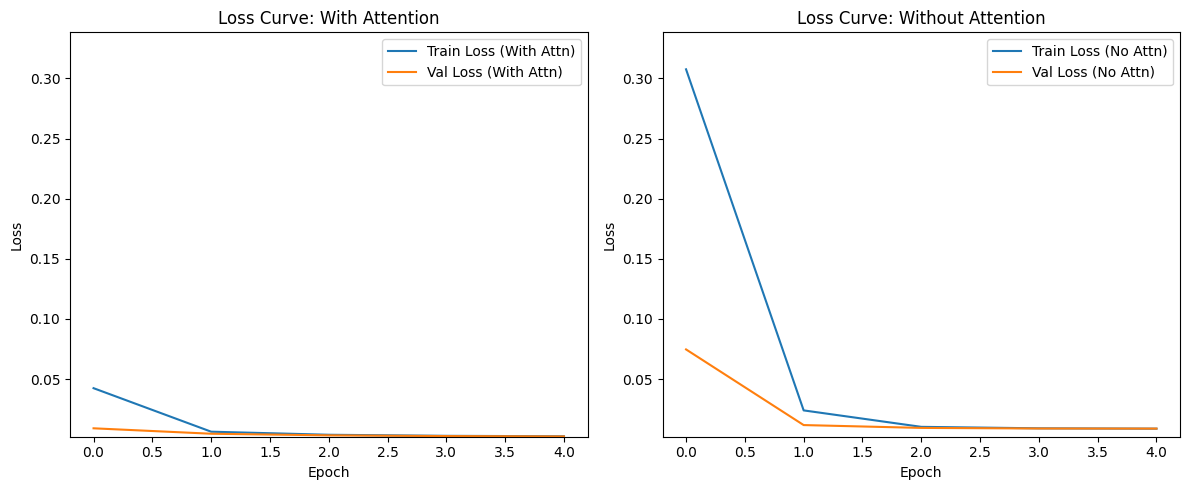

Plotting sample predictions for the model WITH attention...
2092
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


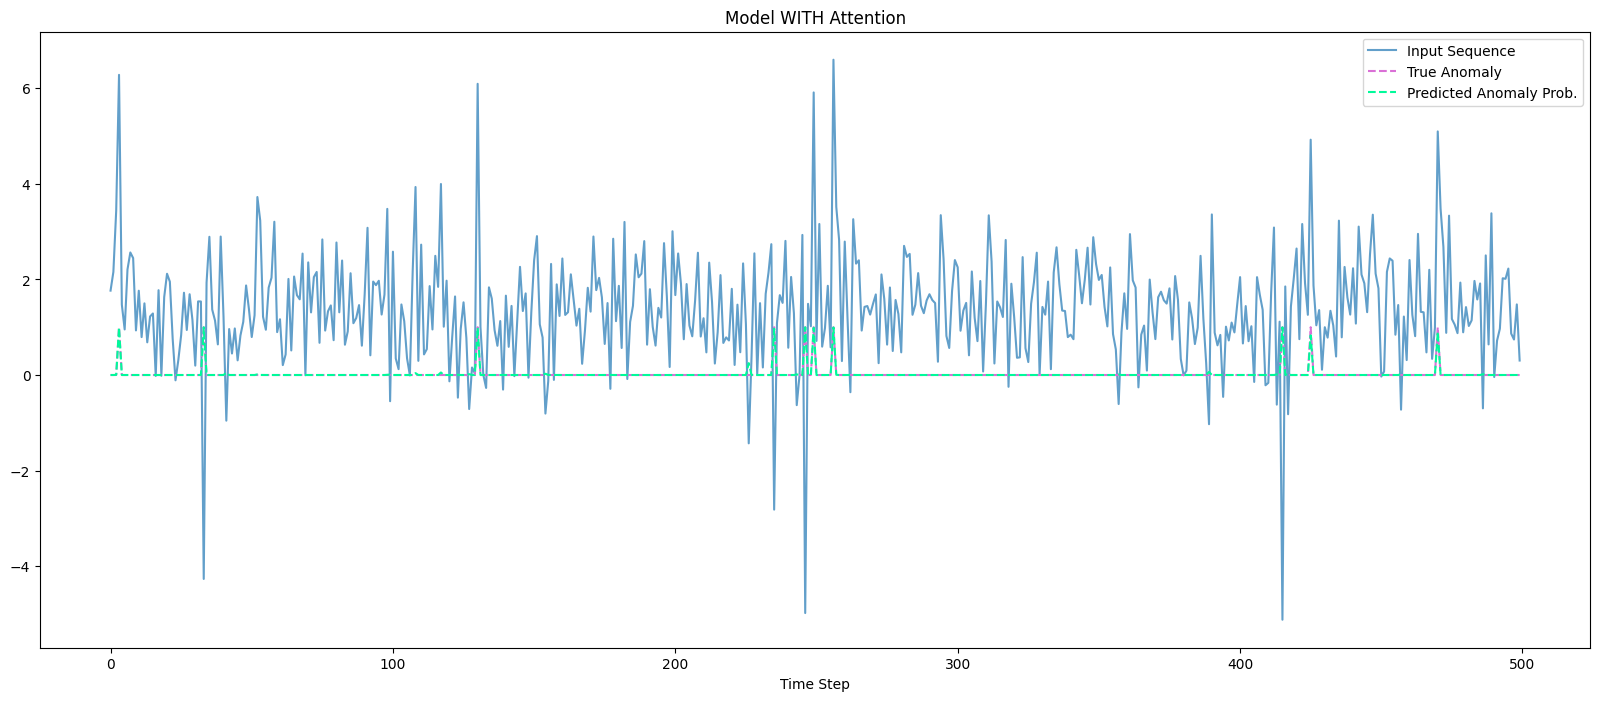

Plotting sample predictions for the model WITHOUT attention...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


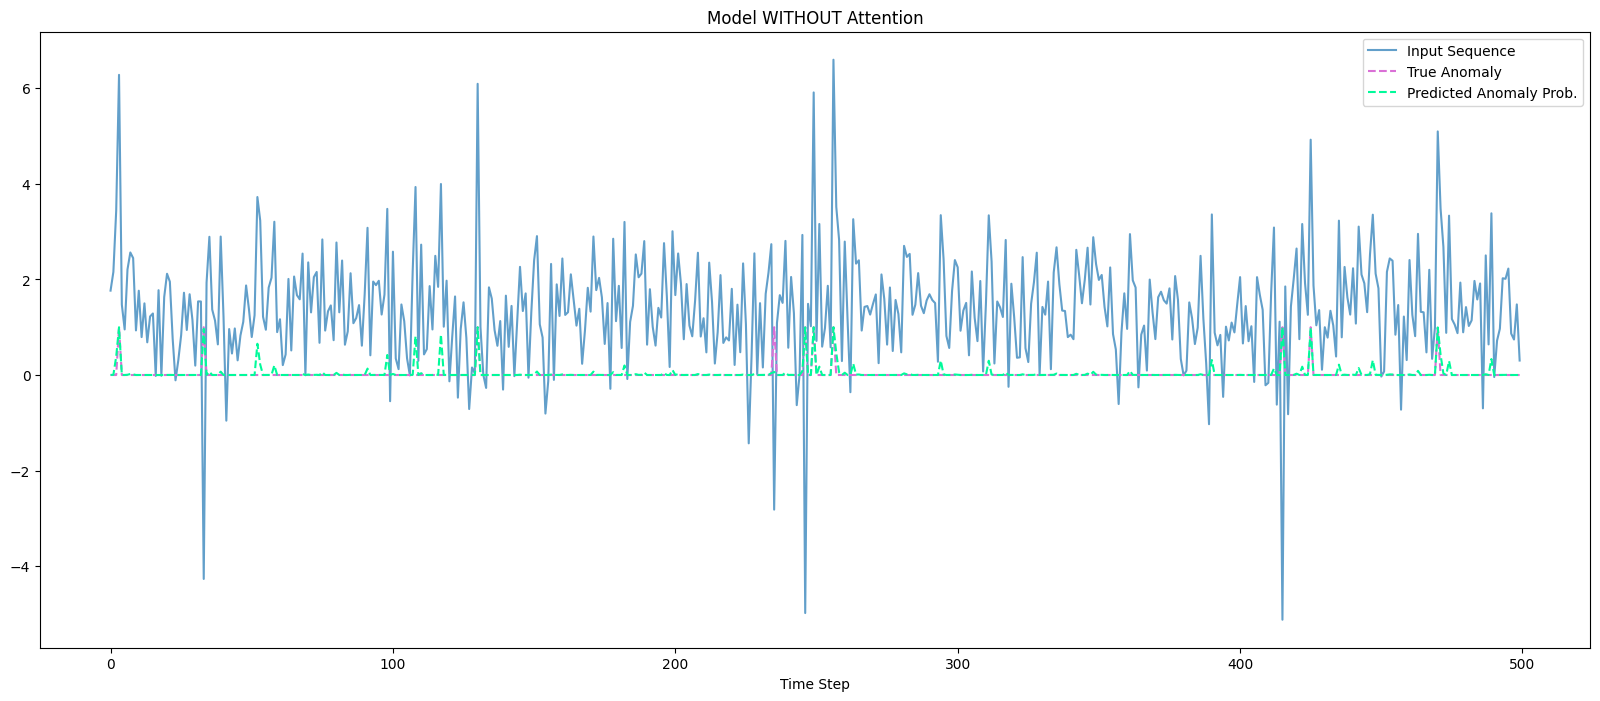

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Data Generation ---
def generate_data(n_samples=10000, seq_length=50, n_anomaly=3):
    """
    Generates synthetic data: each sample is a sequence of numbers drawn from a normal distribution.
    A single anomaly is introduced in each sequence by adding a large spike (or dip).

    Returns:
      X: numpy array, shape (n_samples, seq_length, 1) with input sequences.
      Y: numpy array, shape (n_samples, seq_length, 1) with binary labels:
         1 at the anomaly position, 0 elsewhere.
    """
    X, Y = [], []
    for _ in range(n_samples):
        # Base sequence: normally distributed numbers
        seq = np.random.normal(loc=2*np.random.rand()-1, scale=np.random.rand(), size=seq_length)+np.sin(_*seq_length)
        labels = np.zeros(seq_length)
        # Randomly choose an anomaly index and add a noticeable spike/dip (anomaly)
        anomaly_indexes = np.random.randint(0, seq_length, n_anomaly)
        for anomaly_index in anomaly_indexes:
          # Choose a spike or a dip
          seq[anomaly_index] += np.random.choice([10, -10])/2#3
          labels[anomaly_index] = 1
        X.append(seq)
        Y.append(labels)

    X = np.array(X)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    Y = np.array(Y)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    return X, Y

# --- Model Definitions ---
def build_model_with_attention(seq_length, d_model=32, num_heads=4):
    """
    Builds a simple transformer-like model that applies a multi-head attention layer.

    The model projects the single input feature into a d_model dimensional space, runs
    a multi-head attention over the same sequence (self-attention), adds a residual connection,
    and then applies a couple of feedforward layers to generate a per-time-step anomaly score.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # First, project the input to d_model dimensions.
    x = tf.keras.layers.Dense(d_model)(inputs)
    # Apply multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    # Add residual connection and normalize
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    # A simple feed-forward network on each time step
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    # Output a probability (using sigmoid) per time step.
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_model_without_attention(seq_length, d_model=32):
    """
    Builds a simplified model that does not use any attention.

    The architecture uses two dense layers to process the input sequence and then
    outputs anomaly probabilities per time step.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # Process with dense layers instead of attention
    x = tf.keras.layers.Dense(d_model, activation='relu')(inputs)
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# --- Plotting Helpers ---
def plot_predictions(model, X_test, y_test, title, idx):
    """
    Plots a random test sequence showing:
      - The input sequence values.
      - The true anomaly position.
      - The predicted anomaly probability per time step.
    """
    preds = model.predict(X_test)
    #idx = np.random.randint(0, len(X_test))
    plt.figure(figsize=(20, 8))
    plt.plot(X_test[idx].flatten(), label='Input Sequence', alpha=.7)
    plt.plot(y_test[idx].flatten(), label='True Anomaly', linestyle='--', color='orchid')
    plt.plot(preds[idx].flatten(), label='Predicted Anomaly Prob.', linestyle='--', color='mediumspringgreen')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.legend()
    plt.show()

# --- Main Script ---
def main():
    # Set sequence length and generate training and test data.
    seq_length = 500
    n_anomaly = 10
    X_train, y_train = generate_data(n_samples=10000, seq_length=seq_length, n_anomaly=n_anomaly)
    X_test, y_test = generate_data(n_samples=10000, seq_length=seq_length, n_anomaly=n_anomaly)

    epochs = 5
    # --- Model with Attention ---
    model_attn = build_model_with_attention(seq_length)
    print("Training model WITH attention...")
    history_attn = model_attn.fit(X_train, y_train, validation_split=0.2,
                                  epochs=epochs, batch_size=32, verbose=1)

    # --- Model without Attention ---
    model_no_attn = build_model_without_attention(seq_length)
    print("\nTraining model WITHOUT attention...")
    history_no_attn = model_no_attn.fit(X_train, y_train, validation_split=0.2,
                                        epochs=epochs, batch_size=32, verbose=1)

    # --- Plot Training Loss Curves ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_attn.history['loss'], label='Train Loss (With Attn)')
    plt.plot(history_attn.history['val_loss'], label='Val Loss (With Attn)')
    plt.title('Loss Curve: With Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_no_attn.history['loss'], label='Train Loss (No Attn)')
    plt.plot(history_no_attn.history['val_loss'], label='Val Loss (No Attn)')
    plt.title('Loss Curve: Without Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Sample Predictions ---
    print("Plotting sample predictions for the model WITH attention...")

    id_test=np.random.randint(0, len(X_test))
    print(id_test)
    plot_predictions(model_attn, X_test, y_test,  "Model WITH Attention", id_test)

    print("Plotting sample predictions for the model WITHOUT attention...")
    plot_predictions(model_no_attn, X_test, y_test, "Model WITHOUT Attention", id_test)



if __name__ == '__main__':
    main()


Training model WITH attention...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9802 - loss: 0.1063 - val_accuracy: 0.9823 - val_loss: 0.0682
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9834 - loss: 0.0672 - val_accuracy: 0.9839 - val_loss: 0.0656
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9839 - loss: 0.0660 - val_accuracy: 0.9840 - val_loss: 0.0651
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9840 - loss: 0.0655 - val_accuracy: 0.9841 - val_loss: 0.0646
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9841 - loss: 0.0649 - val_accuracy: 0.9842 - val_loss: 0.0645

Training model WITHOUT attention...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8742 - loss: 0.4117 - val_accuracy: 0.9802 - val_loss: 0.1107
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9802 - loss: 0.1005 - val_accuracy: 0.9815 - val_loss: 0.0831
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1

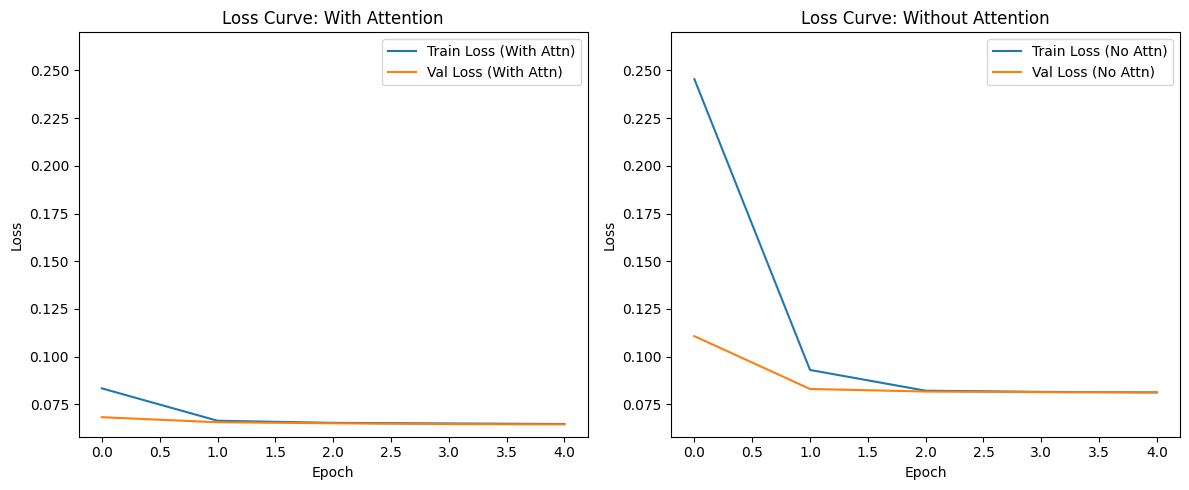

Plotting sample predictions for the model WITH attention...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


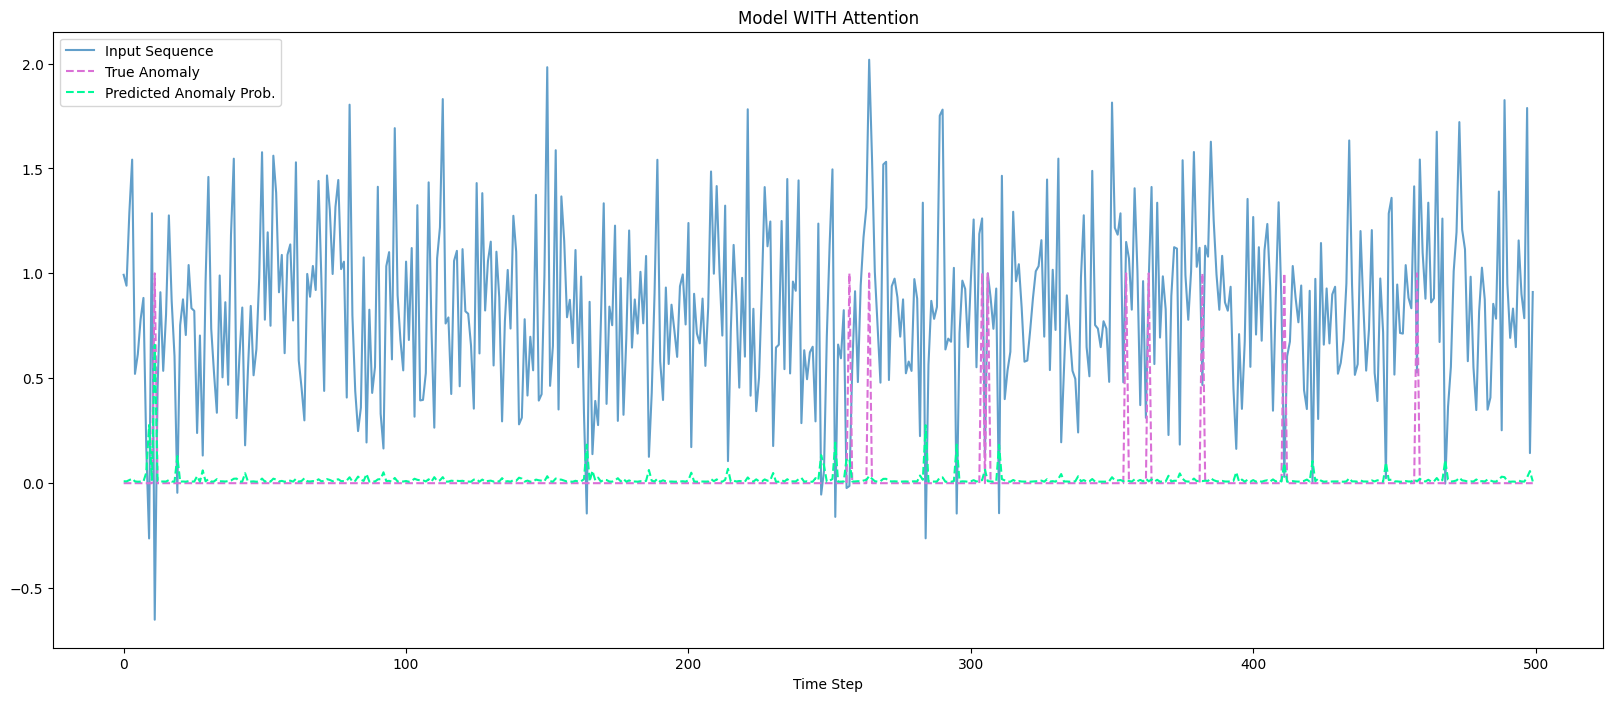

Plotting sample predictions for the model WITHOUT attention...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


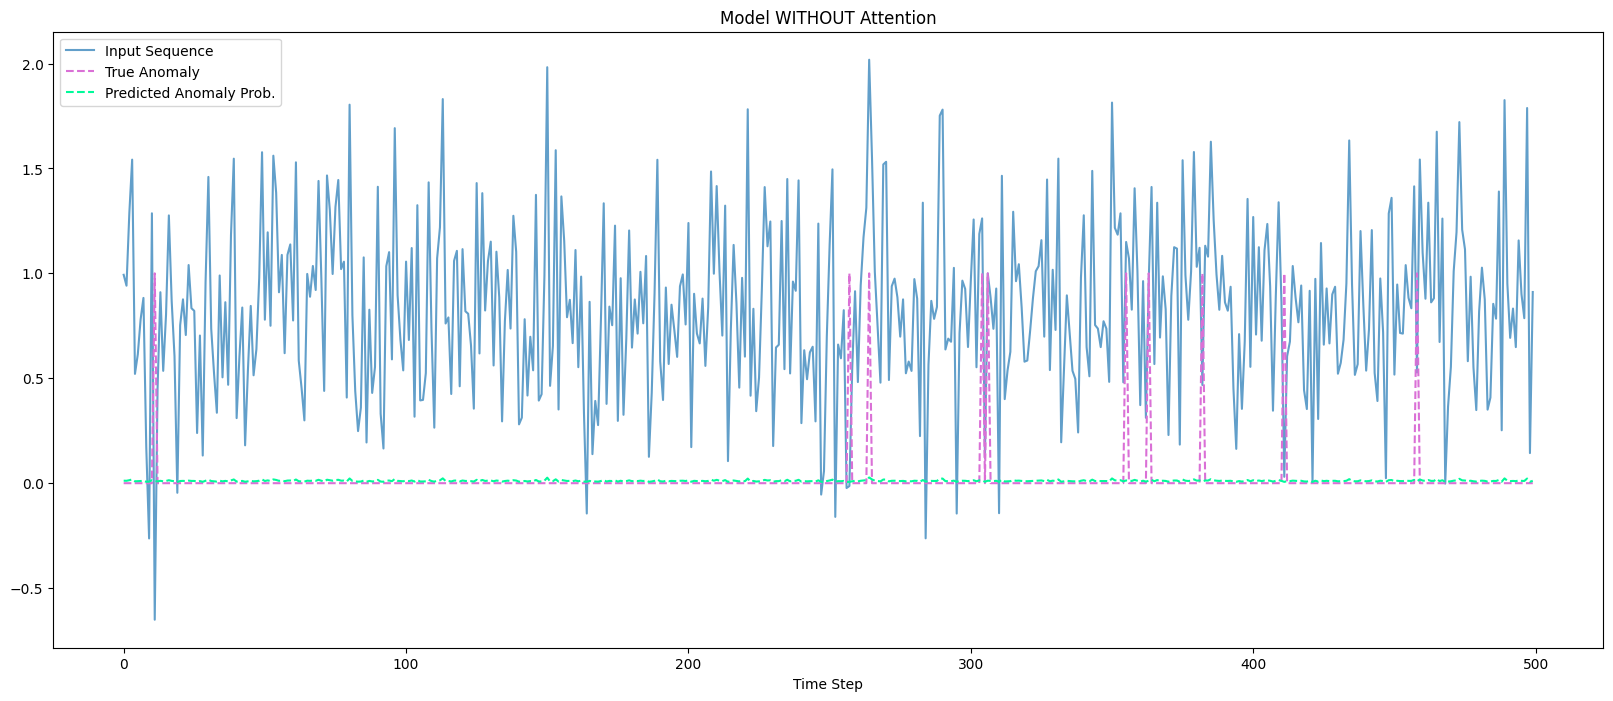

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Data Generation ---
def generate_data(n_samples=10000, seq_length=50, n_anomaly=3):
    """
    Generates synthetic data: each sample is a sequence of numbers drawn from a normal distribution.
    A single anomaly is introduced in each sequence by adding a large spike (or dip).

    Returns:
      X: numpy array, shape (n_samples, seq_length, 1) with input sequences.
      Y: numpy array, shape (n_samples, seq_length, 1) with binary labels:
         1 at the anomaly position, 0 elsewhere.
    """
    X, Y = [], []
    for _ in range(n_samples):
        # Base sequence: normally distributed numbers
        seq = np.random.normal(loc=2*np.random.rand()-1, scale=np.random.rand(), size=seq_length)+np.sin(_*seq_length)
        labels = np.zeros(seq_length)
        # Randomly choose an anomaly index and add a noticeable spike/dip (anomaly)
        anomaly_indexes = np.random.randint(4, seq_length, n_anomaly)
        for anomaly_index in anomaly_indexes:
          # Choose a spike or a dip
          seq[anomaly_index] += 2*np.random.rand()-2 + np.mean(seq[anomaly_index-4:anomaly_index])
          labels[anomaly_index] = 1
        X.append(seq)
        Y.append(labels)

    X = np.array(X)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    Y = np.array(Y)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    return X, Y

# --- Model Definitions ---
def build_model_with_attention(seq_length, d_model=32, num_heads=1):
    """
    Builds a simple transformer-like model that applies a multi-head attention layer.

    The model projects the single input feature into a d_model dimensional space, runs
    a multi-head attention over the same sequence (self-attention), adds a residual connection,
    and then applies a couple of feedforward layers to generate a per-time-step anomaly score.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # First, project the input to d_model dimensions.
    x = tf.keras.layers.Dense(d_model)(inputs)
    # Apply multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    # Add residual connection and normalize
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    # A simple feed-forward network on each time step
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    # Output a probability (using sigmoid) per time step.
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_model_without_attention(seq_length, d_model=32):
    """
    Builds a simplified model that does not use any attention.

    The architecture uses two dense layers to process the input sequence and then
    outputs anomaly probabilities per time step.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # Process with dense layers instead of attention
    x = tf.keras.layers.Dense(d_model, activation='relu')(inputs)
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# --- Plotting Helpers ---
def plot_predictions(model, X_test, y_test, title, idx):
    """
    Plots a random test sequence showing:
      - The input sequence values.
      - The true anomaly position.
      - The predicted anomaly probability per time step.
    """
    preds = model.predict(X_test)
    #idx = np.random.randint(0, len(X_test))
    plt.figure(figsize=(20, 8))
    plt.plot(X_test[idx].flatten(), label='Input Sequence', alpha=.7)
    plt.plot(y_test[idx].flatten(), label='True Anomaly', linestyle='--', color='orchid')
    plt.plot(preds[idx].flatten(), label='Predicted Anomaly Prob.', linestyle='--', color='mediumspringgreen')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.legend()
    plt.show()

# --- Main Script ---
def main():
    # Set sequence length and generate training and test data.
    seq_length = 500
    n_anomaly = 10
    X_train, y_train = generate_data(n_samples=10000, seq_length=seq_length, n_anomaly=n_anomaly)
    X_test, y_test = generate_data(n_samples=10000, seq_length=seq_length, n_anomaly=n_anomaly)

    epochs = 5
    # --- Model with Attention ---
    model_attn = build_model_with_attention(seq_length)
    print("Training model WITH attention...")
    history_attn = model_attn.fit(X_train, y_train, validation_split=0.2,
                                  epochs=epochs, batch_size=32, verbose=1)

    # --- Model without Attention ---
    model_no_attn = build_model_without_attention(seq_length)
    print("\nTraining model WITHOUT attention...")
    history_no_attn = model_no_attn.fit(X_train, y_train, validation_split=0.2,
                                        epochs=epochs, batch_size=32, verbose=1)

    # --- Plot Training Loss Curves ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_attn.history['loss'], label='Train Loss (With Attn)')
    plt.plot(history_attn.history['val_loss'], label='Val Loss (With Attn)')
    plt.title('Loss Curve: With Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_no_attn.history['loss'], label='Train Loss (No Attn)')
    plt.plot(history_no_attn.history['val_loss'], label='Val Loss (No Attn)')
    plt.title('Loss Curve: Without Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Sample Predictions ---
    print("Plotting sample predictions for the model WITH attention...")

    id_test=np.random.randint(0, len(X_test))

    plot_predictions(model_attn, X_test, y_test,  "Model WITH Attention", id_test)

    print("Plotting sample predictions for the model WITHOUT attention...")
    plot_predictions(model_no_attn, X_test, y_test, "Model WITHOUT Attention", id_test)

if __name__ == '__main__':
    main()


Training model WITH attention...
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8363 - loss: 0.3357 - val_accuracy: 0.8788 - val_loss: -0.5017
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8958 - loss: -0.6458 - val_accuracy: 0.9264 - val_loss: -1.0658
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9305 - loss: -1.2079 - val_accuracy: 0.9336 - val_loss: -1.6891
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9340 - loss: -1.8776 - val_accuracy: 0.9345 - val_loss: -2.5300
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9350 - loss: -2.8015 - val_accuracy: 0.9343 - val_loss: -3.6745

Training model WITHOUT attention...
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5266 - loss: 0.4686 - val_accuracy: 0.6499 - val_loss: 0.1991
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6612 - loss: 0.0982 - val_accuracy: 0.6978 - val_loss: -0.2562
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s

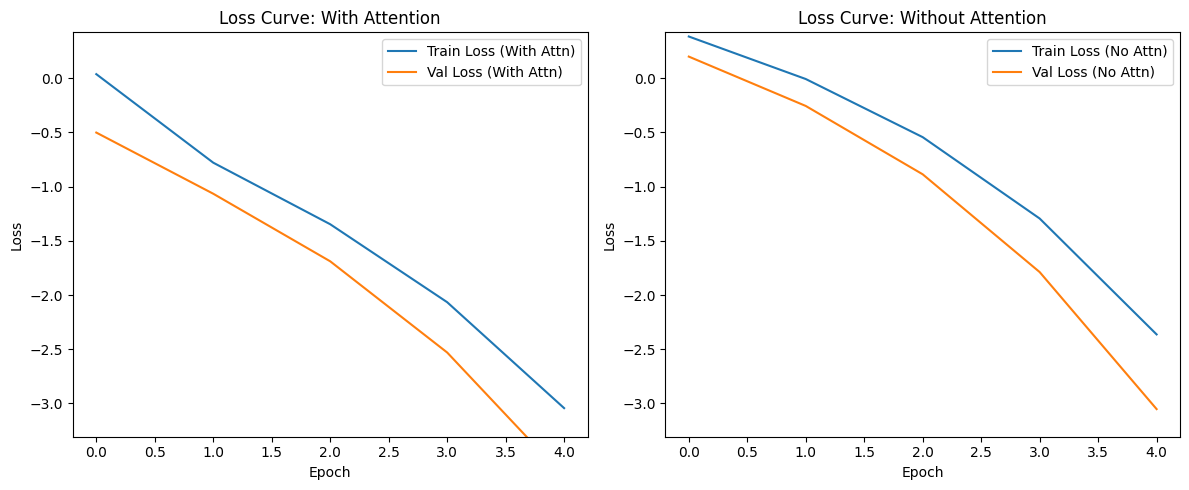

Plotting sample predictions for the model WITH attention...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


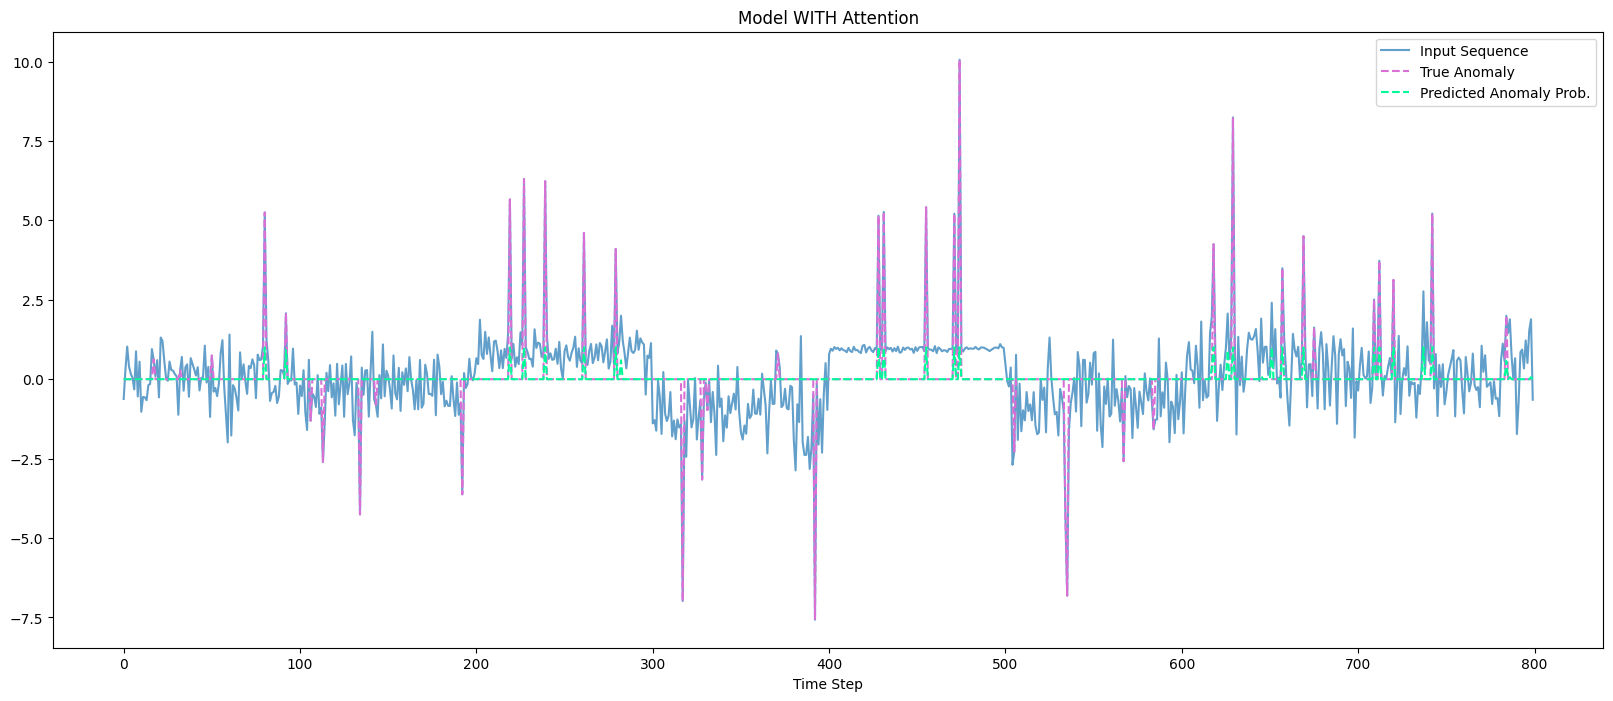

Plotting sample predictions for the model WITHOUT attention...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


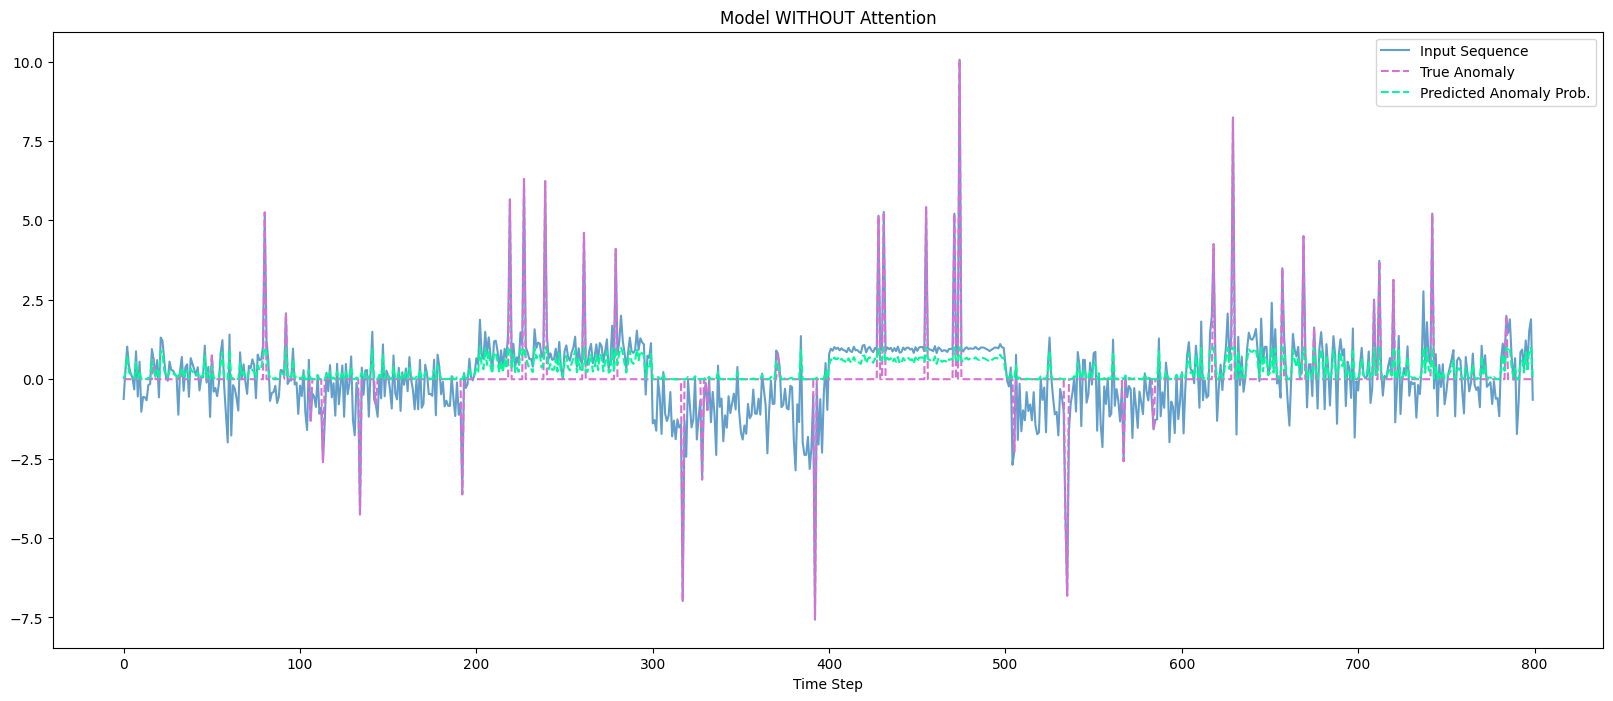

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Data Generation ---
def generate_data(n_samples=10000, n_sequences=10, seq_length=10, n_anomaly=3):
    """
    Generates synthetic data: each sample is a sequence of numbers drawn from a normal distribution.
    A single anomaly is introduced in each sequence by adding a large spike (or dip).

    Returns:
      X: numpy array, shape (n_samples, seq_length, 1) with input sequences.
      Y: numpy array, shape (n_samples, seq_length, 1) with binary labels:
         1 at the anomaly position, 0 elsewhere.
    """
    X, Y = [], []
    mean = 0
    var = 1
    for _ in range(n_samples):
        seq = []
        labels = np.zeros(n_sequences * seq_length)
        for t in range(n_sequences):
          mean = np.sin(123*t)
          var = np.random.rand()
          seq_t = list(np.random.normal(loc=mean, scale=var, size=seq_length))#+np.sin(_*seq_length))
          # Randomly choose an anomaly index and add a noticeable spike/dip (anomaly)
          memory = 4
          anomaly_indexes = np.random.randint(memory, seq_length - memory, n_anomaly)
          for anomaly_index in anomaly_indexes:
            # Choose a spike or a dip
            seq_t[anomaly_index] += 1.5*(var + 3 * np.mean(seq_t[anomaly_index-memory:anomaly_index]))
            labels[t * seq_length + anomaly_index] = seq_t[anomaly_index]#1
          seq += seq_t
        seq = np.array(seq)

        X.append(seq)
        Y.append(labels)

    X = np.array(X)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    Y = np.array(Y)[..., np.newaxis]  # shape: (n_samples, seq_length, 1)
    return X, Y

# --- Model Definitions ---
def build_model_with_attention(seq_length, d_model=32, num_heads=4):
    """
    Builds a simple transformer-like model that applies a multi-head attention layer.

    The model projects the single input feature into a d_model dimensional space, runs
    a multi-head attention over the same sequence (self-attention), adds a residual connection,
    and then applies a couple of feedforward layers to generate a per-time-step anomaly score.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # First, project the input to d_model dimensions.
    x = tf.keras.layers.Dense(d_model)(inputs)
    # Apply multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    # Add residual connection and normalize
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    # A simple feed-forward network on each time step
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    # Output a probability (using sigmoid) per time step.
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_model_without_attention(seq_length, d_model=32):
    """
    Builds a simplified model that does not use any attention.

    The architecture uses two dense layers to process the input sequence and then
    outputs anomaly probabilities per time step.
    """
    inputs = tf.keras.Input(shape=(seq_length, 1))
    # Process with dense layers instead of attention
    x = tf.keras.layers.Dense(d_model, activation='relu')(inputs)
    x = tf.keras.layers.Dense(d_model, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# --- Plotting Helpers ---
def plot_predictions(model, X_test, y_test, title, idx):
    """
    Plots a random test sequence showing:
      - The input sequence values.
      - The true anomaly position.
      - The predicted anomaly probability per time step.
    """
    preds = model.predict(X_test)
    #idx = np.random.randint(0, len(X_test))
    plt.figure(figsize=(20, 8))
    plt.plot(X_test[idx].flatten(), label='Input Sequence', alpha=.7)
    plt.plot(y_test[idx].flatten(), label='True Anomaly', linestyle='--', color='orchid')
    plt.plot(preds[idx].flatten(), label='Predicted Anomaly Prob.', linestyle='--', color='mediumspringgreen')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.legend()
    plt.show()

# --- Main Script ---
def main():
    # Set sequence length and generate training and test data.
    n_samples = 1000
    n_sequences = 8
    seq_length = 100
    n_datapoints = n_sequences * seq_length
    n_anomaly = 5
    X_train, y_train = generate_data(n_samples=n_samples, n_sequences=n_sequences, seq_length=seq_length, n_anomaly=n_anomaly)
    X_test, y_test = generate_data(n_samples=n_samples, n_sequences=n_sequences, seq_length=seq_length, n_anomaly=n_anomaly)


    epochs = 5
    # --- Model with Attention ---
    model_attn = build_model_with_attention(n_datapoints)
    print("Training model WITH attention...")
    history_attn = model_attn.fit(X_train, y_train, validation_split=0.2,
                                  epochs=epochs, batch_size=32, verbose=1)

    # --- Model without Attention ---
    model_no_attn = build_model_without_attention(n_datapoints)
    print("\nTraining model WITHOUT attention...")
    history_no_attn = model_no_attn.fit(X_train, y_train, validation_split=0.2,
                                        epochs=epochs, batch_size=32, verbose=1)

    # --- Plot Training Loss Curves ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_attn.history['loss'], label='Train Loss (With Attn)')
    plt.plot(history_attn.history['val_loss'], label='Val Loss (With Attn)')
    plt.title('Loss Curve: With Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_no_attn.history['loss'], label='Train Loss (No Attn)')
    plt.plot(history_no_attn.history['val_loss'], label='Val Loss (No Attn)')
    plt.title('Loss Curve: Without Attention')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim((.9 * min([min(history_attn.history['loss']), min(history_attn.history['val_loss']), min(history_no_attn.history['loss']), min(history_no_attn.history['val_loss'])]), \
              1.1 * max([max(history_attn.history['loss']), max(history_attn.history['val_loss']), max(history_no_attn.history['loss']), max(history_no_attn.history['val_loss'])])))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Sample Predictions ---
    print("Plotting sample predictions for the model WITH attention...")

    id_test=np.random.randint(0, len(X_test))

    plot_predictions(model_attn, X_test, y_test,  "Model WITH Attention", id_test)

    print("Plotting sample predictions for the model WITHOUT attention...")
    plot_predictions(model_no_attn, X_test, y_test, "Model WITHOUT Attention", id_test)

if __name__ == '__main__':
    main()
